In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import copy
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# for creating validation set
from sklearn.model_selection import train_test_split

%matplotlib notebook
%matplotlib notebook
# %matplotlib inline
# %matplotlib qt

In [3]:
import sys

sys.path.append('/media/rich/Home_Linux_partition/github_repos/')

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, decomposition
from GCaMP_ROI_classifier.old_stuff import util, models, training_simCLR, augmentation

## Import training data

In [4]:
import pickle

with open('/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data/all_stat_files_20211022.pkl', 'rb') as file:
    statFiles_scraped = pickle.load(file)

In [5]:
keys_toDelete = [
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\16x_analysis20200514\\Suite2p and MC for denoised movie\\suite2p\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20201102\\suite2p_accidentally_run_on_everything\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attemp 2 _tau 1_5\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 1 _tau 2\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 3 _tau 1\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\AAV\\oldBMIrampExp_20191112_mouse1013A\\ROI extraction\\suite2p\\plane0\\stat.npy',
]
for key in keys_toDelete:
    del statFiles_scraped[key]

In [6]:
sf_list = util.convert_multiple_stat_files(statFiles_dict=statFiles_scraped, out_height_width=[36,36], max_footprint_width=901, plot_pref=False)

images_all = np.concatenate(sf_list, axis=0)

images_all.shape

(217802, 36, 36)

In [7]:
images_all_norm = (images_all / np.sum(images_all, axis=(1,2), keepdims=True)) * 255

In [8]:
# create validation set
# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(images_all_norm, np.arange(images_all.shape[0]), test_size = 0.15)
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

(((185131, 36, 36), (185131,)), ((32671, 36, 36), (32671,)))

<IPython.core.display.Javascript object>


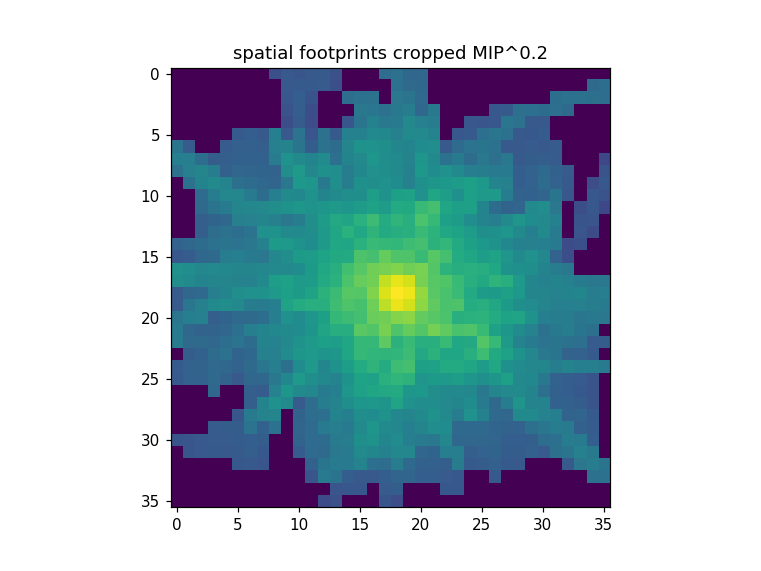

<IPython.core.display.Javascript object>


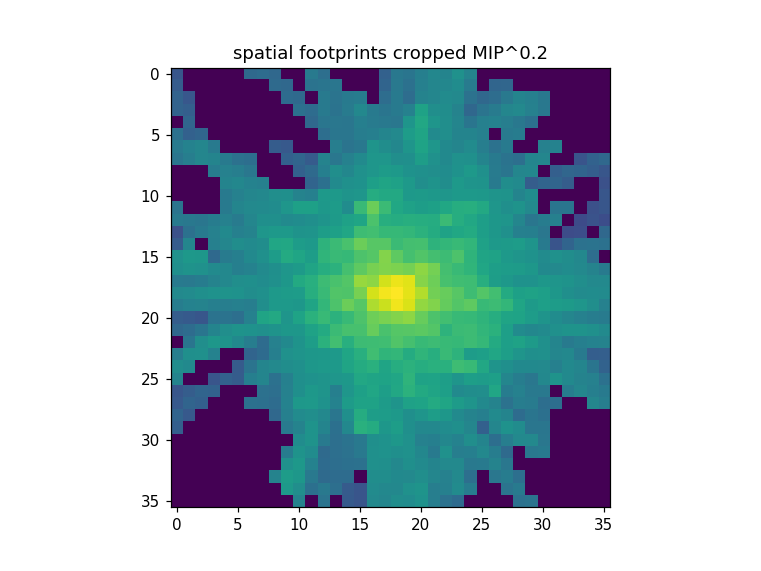

concatenated images shape: (9715, 36, 36)


<IPython.core.display.Javascript object>


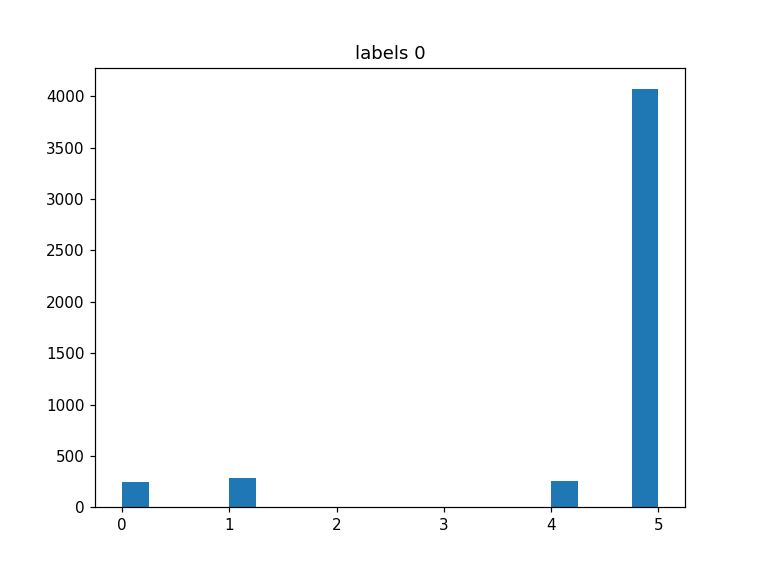

<IPython.core.display.Javascript object>


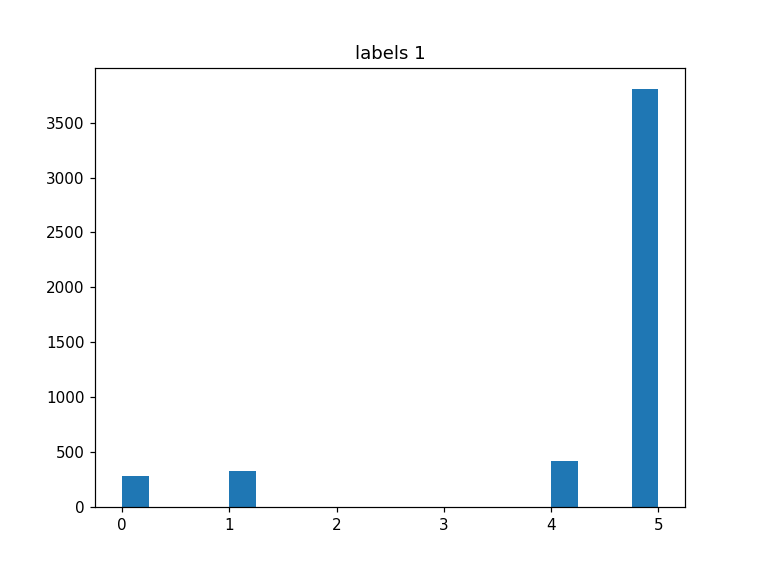

In [9]:
dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

statFile_import_kwargs = {'out_height_width': [36,36],
                          'max_footprint_width': 241,
                          'plot_pref':True}

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                        fileNames_statFiles=fileNames_statFiles,
                                        out_height_width=[36,36],
                                        max_footprint_width=241,
                                        plot_pref=True)
images_labeled = np.concatenate(sf_all, axis=0) *255
print(f'concatenated images shape: {images_labeled.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

## Balance classes of inputs

## Define augmentation pipeline

In [82]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    
    torchvision.transforms.GaussianBlur(kernel_size=5,
                                        sigma=(0.0001, 0.3)),
    
    torchvision.transforms.RandomPerspective(distortion_scale=0.3, 
                                             p=0.7, 
                                             interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                             fill=0),
    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.3, 0.3),
                                        scale=(0.7, 1.5), 
                                        shear=(-20, 20, -20, 20), 
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        fillcolor=None, 
                                        resample=None),
    
    augmentation.AddPoissonNoise(   level_bounds=(0,0.4),
                                    prob=1),

    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.3,
                                    prob=1),
)
scripted_transforms = torch.jit.script(transforms)
# scripted_transforms = transforms


dataset_train = util.dataset_simCLR(torch.tensor(X_train), 
                                    y_train, 
                                    n_transforms=2, 
                                    transform=scripted_transforms,
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64 )

dataloader_train = torch.utils.data.DataLoader( dataset_train,
                                                batch_size=1024,
            #                                     sampler=sampler,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=24,
                                                prefetch_factor=128,
                                                persistent_workers=True,
                                                )

# dataset_val = util.dataset_simCLR(torch.tensor(X_val), 
#                                     y_val, 
#                                     n_transforms=2, 
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64 )

# dataloader_val = torch.utils.data.DataLoader(   dataset_val,
#                                                 batch_size=128,
#             #                                     sampler=sampler,
#                                                 shuffle=True,
#                                                 drop_last=True,
#                                                 pin_memory=True,
#                                                 num_workers=0,
#                                                 )

## Train

In [69]:
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda'


In [70]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=128)
model.train()
criterion = CrossEntropyLoss()

In [71]:
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.00001,
#                                                    gamma=1,
                                                  )
val_obj = training_simCLR.validation_Obj(   X_val,
                                            y_val,
                                            model,
                                            criterion,
                                            DEVICE=DEVICE,
                                            dtype_X=torch.float32,
                                            dtype_y=torch.int64)

model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses_train, losses_val, val_accs = [], [np.nan], []

In [83]:
n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    training_simCLR.epoch_step( dataloader_train, 
                                model, 
                                optimizer, 
                                criterion, 
                                scheduler=scheduler, 
                                temperature=0.5,
                                loss_rolling_train=losses_train, 
                                device=DEVICE, 
                                do_validation=False,
                                validation_Object=val_obj,
                                loss_rolling_val=losses_val,
                                verbose=2,
                                verbose_update_period=100,
                               )

epoch: 0
Iter: 0/180, loss_train: 6.219, loss_val: nan, lr: 0.00095837
Iter: 100/180, loss_train: 6.2006, loss_val: nan, lr: 0.00095741
epoch: 1
Iter: 0/180, loss_train: 6.1864, loss_val: nan, lr: 0.00095665
Iter: 100/180, loss_train: 6.2221, loss_val: nan, lr: 0.00095569
epoch: 2
Iter: 0/180, loss_train: 6.2278, loss_val: nan, lr: 0.00095493
Iter: 100/180, loss_train: 6.1938, loss_val: nan, lr: 0.00095397
epoch: 3
Iter: 0/180, loss_train: 6.2092, loss_val: nan, lr: 0.00095321
Iter: 100/180, loss_train: 6.2066, loss_val: nan, lr: 0.00095226


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f274fe519d0>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f274fe519d0>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/p

epoch: 4
Iter: 0/180, loss_train: 6.2073, loss_val: nan, lr: 0.0009515


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f274fe519d0>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f274fe519d0>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/p

    if w.is_alive():
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f274fe519d0>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 

Iter: 100/180, loss_train: 6.2104, loss_val: nan, lr: 0.00095054


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f274fe519d0>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f274fe519d0>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/p

epoch: 5
Iter: 0/180, loss_train: 6.2216, loss_val: nan, lr: 0.00094978
Iter: 100/180, loss_train: 6.1951, loss_val: nan, lr: 0.00094884
epoch: 6
Iter: 0/180, loss_train: 6.2093, loss_val: nan, lr: 0.00094808
Iter: 100/180, loss_train: 6.2369, loss_val: nan, lr: 0.00094713
epoch: 7
Iter: 0/180, loss_train: 6.2457, loss_val: nan, lr: 0.00094637
Iter: 100/180, loss_train: 6.2309, loss_val: nan, lr: 0.00094543
epoch: 8
Iter: 0/180, loss_train: 6.2192, loss_val: nan, lr: 0.00094467
Iter: 100/180, loss_train: 6.2059, loss_val: nan, lr: 0.00094373
epoch: 9
Iter: 0/180, loss_train: 6.2231, loss_val: nan, lr: 0.00094297
Iter: 100/180, loss_train: 6.1964, loss_val: nan, lr: 0.00094203
epoch: 10
Iter: 0/180, loss_train: 6.2062, loss_val: nan, lr: 0.00094127
Iter: 100/180, loss_train: 6.2163, loss_val: nan, lr: 0.00094033
epoch: 11
Iter: 0/180, loss_train: 6.2109, loss_val: nan, lr: 0.00093958
Iter: 100/180, loss_train: 6.2142, loss_val: nan, lr: 0.00093864
epoch: 12
Iter: 0/180, loss_train: 6.20

epoch: 65
Iter: 0/180, loss_train: 6.2038, loss_val: nan, lr: 0.00085255
Iter: 100/180, loss_train: 6.1701, loss_val: nan, lr: 0.0008517
epoch: 66
Iter: 0/180, loss_train: 6.1934, loss_val: nan, lr: 0.00085102
Iter: 100/180, loss_train: 6.1931, loss_val: nan, lr: 0.00085017
epoch: 67
Iter: 0/180, loss_train: 6.1891, loss_val: nan, lr: 0.00084949
Iter: 100/180, loss_train: 6.1812, loss_val: nan, lr: 0.00084864
epoch: 68
Iter: 0/180, loss_train: 6.2149, loss_val: nan, lr: 0.00084796
Iter: 100/180, loss_train: 6.1859, loss_val: nan, lr: 0.00084711
epoch: 69
Iter: 0/180, loss_train: 6.2111, loss_val: nan, lr: 0.00084644
Iter: 100/180, loss_train: 6.1924, loss_val: nan, lr: 0.00084559
epoch: 70
Iter: 0/180, loss_train: 6.2065, loss_val: nan, lr: 0.00084491
Iter: 100/180, loss_train: 6.2107, loss_val: nan, lr: 0.00084407
epoch: 71
Iter: 0/180, loss_train: 6.1986, loss_val: nan, lr: 0.00084339
Iter: 100/180, loss_train: 6.1938, loss_val: nan, lr: 0.00084255
epoch: 72
Iter: 0/180, loss_train: 

Iter: 100/180, loss_train: 6.1858, loss_val: nan, lr: 0.00076589
epoch: 125
Iter: 0/180, loss_train: 6.1796, loss_val: nan, lr: 0.00076527
Iter: 100/180, loss_train: 6.1758, loss_val: nan, lr: 0.00076451
epoch: 126
Iter: 0/180, loss_train: 6.1819, loss_val: nan, lr: 0.0007639
Iter: 100/180, loss_train: 6.1798, loss_val: nan, lr: 0.00076313
epoch: 127
Iter: 0/180, loss_train: 6.176, loss_val: nan, lr: 0.00076252
Iter: 100/180, loss_train: 6.1702, loss_val: nan, lr: 0.00076176
epoch: 128
Iter: 0/180, loss_train: 6.1837, loss_val: nan, lr: 0.00076115
Iter: 100/180, loss_train: 6.1791, loss_val: nan, lr: 0.00076039
epoch: 129
Iter: 0/180, loss_train: 6.1852, loss_val: nan, lr: 0.00075978
Iter: 100/180, loss_train: 6.1766, loss_val: nan, lr: 0.00075902
epoch: 130
Iter: 0/180, loss_train: 6.1937, loss_val: nan, lr: 0.00075842
Iter: 100/180, loss_train: 6.1659, loss_val: nan, lr: 0.00075766
epoch: 131
Iter: 0/180, loss_train: 6.15, loss_val: nan, lr: 0.00075705
Iter: 100/180, loss_train: 6.17

epoch: 184
Iter: 0/180, loss_train: 6.1649, loss_val: nan, lr: 0.00068817
Iter: 100/180, loss_train: 6.1702, loss_val: nan, lr: 0.00068748
epoch: 185
Iter: 0/180, loss_train: 6.1677, loss_val: nan, lr: 0.00068693
Iter: 100/180, loss_train: 6.2166, loss_val: nan, lr: 0.00068624
epoch: 186
Iter: 0/180, loss_train: 6.1839, loss_val: nan, lr: 0.0006857
Iter: 100/180, loss_train: 6.1554, loss_val: nan, lr: 0.00068501
epoch: 187
Iter: 0/180, loss_train: 6.1883, loss_val: nan, lr: 0.00068446
Iter: 100/180, loss_train: 6.1842, loss_val: nan, lr: 0.00068378
epoch: 188
Iter: 0/180, loss_train: 6.1831, loss_val: nan, lr: 0.00068323
Iter: 100/180, loss_train: 6.1696, loss_val: nan, lr: 0.00068255
epoch: 189
Iter: 0/180, loss_train: 6.1807, loss_val: nan, lr: 0.000682
Iter: 100/180, loss_train: 6.1957, loss_val: nan, lr: 0.00068132
epoch: 190
Iter: 0/180, loss_train: 6.1749, loss_val: nan, lr: 0.00068078
Iter: 100/180, loss_train: 6.1729, loss_val: nan, lr: 0.0006801
epoch: 191
Iter: 0/180, loss_tr

Iter: 100/180, loss_train: 6.185, loss_val: nan, lr: 0.00061821
epoch: 244
Iter: 0/180, loss_train: 6.1788, loss_val: nan, lr: 0.00061772
Iter: 100/180, loss_train: 6.178, loss_val: nan, lr: 0.0006171
epoch: 245
Iter: 0/180, loss_train: 6.1805, loss_val: nan, lr: 0.00061661
Iter: 100/180, loss_train: 6.1729, loss_val: nan, lr: 0.00061599
epoch: 246
Iter: 0/180, loss_train: 6.1782, loss_val: nan, lr: 0.0006155
Iter: 100/180, loss_train: 6.1847, loss_val: nan, lr: 0.00061488
epoch: 247
Iter: 0/180, loss_train: 6.1859, loss_val: nan, lr: 0.00061439
Iter: 100/180, loss_train: 6.1902, loss_val: nan, lr: 0.00061378
epoch: 248
Iter: 0/180, loss_train: 6.1504, loss_val: nan, lr: 0.00061329
Iter: 100/180, loss_train: 6.1681, loss_val: nan, lr: 0.00061267
epoch: 249
Iter: 0/180, loss_train: 6.1522, loss_val: nan, lr: 0.00061218
Iter: 100/180, loss_train: 6.1677, loss_val: nan, lr: 0.00061157
epoch: 250
Iter: 0/180, loss_train: 6.1564, loss_val: nan, lr: 0.00061108
Iter: 100/180, loss_train: 6.17

epoch: 303
Iter: 0/180, loss_train: 6.1772, loss_val: nan, lr: 0.00055548
Iter: 100/180, loss_train: 6.164, loss_val: nan, lr: 0.00055492
epoch: 304
Iter: 0/180, loss_train: 6.1709, loss_val: nan, lr: 0.00055448
Iter: 100/180, loss_train: 6.1408, loss_val: nan, lr: 0.00055393
epoch: 305
Iter: 0/180, loss_train: 6.1475, loss_val: nan, lr: 0.00055348
Iter: 100/180, loss_train: 6.1748, loss_val: nan, lr: 0.00055293
epoch: 306
Iter: 0/180, loss_train: 6.1964, loss_val: nan, lr: 0.00055249
Iter: 100/180, loss_train: 6.1726, loss_val: nan, lr: 0.00055194
epoch: 307
Iter: 0/180, loss_train: 6.1499, loss_val: nan, lr: 0.00055149
Iter: 100/180, loss_train: 6.1905, loss_val: nan, lr: 0.00055094
epoch: 308
Iter: 0/180, loss_train: 6.1586, loss_val: nan, lr: 0.0005505
Iter: 100/180, loss_train: 6.1865, loss_val: nan, lr: 0.00054995
epoch: 309
Iter: 0/180, loss_train: 6.1543, loss_val: nan, lr: 0.00054951
Iter: 100/180, loss_train: 6.1879, loss_val: nan, lr: 0.00054896
epoch: 310
Iter: 0/180, loss_

Iter: 0/180, loss_train: 6.146, loss_val: nan, lr: 0.00049951
Iter: 100/180, loss_train: 6.1736, loss_val: nan, lr: 0.00049901
epoch: 363
Iter: 0/180, loss_train: 6.1516, loss_val: nan, lr: 0.00049861
Iter: 100/180, loss_train: 6.1589, loss_val: nan, lr: 0.00049812
epoch: 364
Iter: 0/180, loss_train: 6.1666, loss_val: nan, lr: 0.00049772
Iter: 100/180, loss_train: 6.1642, loss_val: nan, lr: 0.00049722
epoch: 365
Iter: 0/180, loss_train: 6.1596, loss_val: nan, lr: 0.00049682
Iter: 100/180, loss_train: 6.1641, loss_val: nan, lr: 0.00049633
epoch: 366
Iter: 0/180, loss_train: 6.1719, loss_val: nan, lr: 0.00049593
Iter: 100/180, loss_train: 6.1473, loss_val: nan, lr: 0.00049543
epoch: 367
Iter: 0/180, loss_train: 6.1712, loss_val: nan, lr: 0.00049504
Iter: 100/180, loss_train: 6.1523, loss_val: nan, lr: 0.00049454
epoch: 368
Iter: 0/180, loss_train: 6.1594, loss_val: nan, lr: 0.00049415
Iter: 100/180, loss_train: 6.1707, loss_val: nan, lr: 0.00049365
epoch: 369
Iter: 0/180, loss_train: 6.1

Iter: 100/180, loss_train: 6.1492, loss_val: nan, lr: 0.00044873
epoch: 422
Iter: 0/180, loss_train: 6.1366, loss_val: nan, lr: 0.00044838
Iter: 100/180, loss_train: 6.1554, loss_val: nan, lr: 0.00044793
epoch: 423
Iter: 0/180, loss_train: 6.1408, loss_val: nan, lr: 0.00044757
Iter: 100/180, loss_train: 6.1357, loss_val: nan, lr: 0.00044712
epoch: 424
Iter: 0/180, loss_train: 6.1638, loss_val: nan, lr: 0.00044676
Iter: 100/180, loss_train: 6.1636, loss_val: nan, lr: 0.00044632
epoch: 425
Iter: 0/180, loss_train: 6.1539, loss_val: nan, lr: 0.00044596
Iter: 100/180, loss_train: 6.1586, loss_val: nan, lr: 0.00044552
epoch: 426
Iter: 0/180, loss_train: 6.1772, loss_val: nan, lr: 0.00044516
Iter: 100/180, loss_train: 6.1557, loss_val: nan, lr: 0.00044471
epoch: 427
Iter: 0/180, loss_train: 6.1756, loss_val: nan, lr: 0.00044436
Iter: 100/180, loss_train: 6.1604, loss_val: nan, lr: 0.00044391
epoch: 428
Iter: 0/180, loss_train: 6.1314, loss_val: nan, lr: 0.00044356
Iter: 100/180, loss_train: 

epoch: 481
Iter: 0/180, loss_train: 6.1604, loss_val: nan, lr: 0.0004032
Iter: 100/180, loss_train: 6.1541, loss_val: nan, lr: 0.0004028
epoch: 482
Iter: 0/180, loss_train: 6.1384, loss_val: nan, lr: 0.00040247
Iter: 100/180, loss_train: 6.1538, loss_val: nan, lr: 0.00040207
epoch: 483
Iter: 0/180, loss_train: 6.1375, loss_val: nan, lr: 0.00040175
Iter: 100/180, loss_train: 6.1536, loss_val: nan, lr: 0.00040135
epoch: 484
Iter: 0/180, loss_train: 6.1665, loss_val: nan, lr: 0.00040103
Iter: 100/180, loss_train: 6.1545, loss_val: nan, lr: 0.00040063
epoch: 485
Iter: 0/180, loss_train: 6.152, loss_val: nan, lr: 0.00040031
Iter: 100/180, loss_train: 6.173, loss_val: nan, lr: 0.00039991
epoch: 486
Iter: 0/180, loss_train: 6.1564, loss_val: nan, lr: 0.00039959
Iter: 100/180, loss_train: 6.1572, loss_val: nan, lr: 0.00039919
epoch: 487
Iter: 0/180, loss_train: 6.1438, loss_val: nan, lr: 0.00039887
Iter: 100/180, loss_train: 6.1404, loss_val: nan, lr: 0.00039847
epoch: 488
Iter: 0/180, loss_tr

Iter: 100/180, loss_train: 6.1524, loss_val: nan, lr: 0.00036221
epoch: 541
Iter: 0/180, loss_train: 6.1637, loss_val: nan, lr: 0.00036192
Iter: 100/180, loss_train: 6.1416, loss_val: nan, lr: 0.00036156
epoch: 542
Iter: 0/180, loss_train: 6.1601, loss_val: nan, lr: 0.00036127
Iter: 100/180, loss_train: 6.1464, loss_val: nan, lr: 0.00036091
epoch: 543
Iter: 0/180, loss_train: 6.1545, loss_val: nan, lr: 0.00036062
Iter: 100/180, loss_train: 6.1588, loss_val: nan, lr: 0.00036026
epoch: 544
Iter: 0/180, loss_train: 6.1549, loss_val: nan, lr: 0.00035997
Iter: 100/180, loss_train: 6.162, loss_val: nan, lr: 0.00035961
epoch: 545
Iter: 0/180, loss_train: 6.1625, loss_val: nan, lr: 0.00035933
Iter: 100/180, loss_train: 6.1787, loss_val: nan, lr: 0.00035897
epoch: 546
Iter: 0/180, loss_train: 6.1673, loss_val: nan, lr: 0.00035868
Iter: 100/180, loss_train: 6.1525, loss_val: nan, lr: 0.00035832
epoch: 547
Iter: 0/180, loss_train: 6.1872, loss_val: nan, lr: 0.00035803
Iter: 100/180, loss_train: 6

epoch: 600
Iter: 0/180, loss_train: 6.1553, loss_val: nan, lr: 0.00032546
Iter: 100/180, loss_train: 6.1567, loss_val: nan, lr: 0.00032513
epoch: 601
Iter: 0/180, loss_train: 6.1473, loss_val: nan, lr: 0.00032487
Iter: 100/180, loss_train: 6.1334, loss_val: nan, lr: 0.00032455
epoch: 602
Iter: 0/180, loss_train: 6.1469, loss_val: nan, lr: 0.00032429
Iter: 100/180, loss_train: 6.1579, loss_val: nan, lr: 0.00032396
epoch: 603
Iter: 0/180, loss_train: 6.1593, loss_val: nan, lr: 0.0003237
Iter: 100/180, loss_train: 6.1442, loss_val: nan, lr: 0.00032338
epoch: 604
Iter: 0/180, loss_train: 6.1412, loss_val: nan, lr: 0.00032312
Iter: 100/180, loss_train: 6.161, loss_val: nan, lr: 0.0003228
epoch: 605
Iter: 0/180, loss_train: 6.155, loss_val: nan, lr: 0.00032254
Iter: 100/180, loss_train: 6.1595, loss_val: nan, lr: 0.00032222
epoch: 606
Iter: 0/180, loss_train: 6.1405, loss_val: nan, lr: 0.00032196
Iter: 100/180, loss_train: 6.1454, loss_val: nan, lr: 0.00032164
epoch: 607
Iter: 0/180, loss_tr

Iter: 100/180, loss_train: 6.1505, loss_val: nan, lr: 0.00029237
epoch: 660
Iter: 0/180, loss_train: 6.1199, loss_val: nan, lr: 0.00029214
Iter: 100/180, loss_train: 6.1487, loss_val: nan, lr: 0.00029185
epoch: 661
Iter: 0/180, loss_train: 6.1516, loss_val: nan, lr: 0.00029161
Iter: 100/180, loss_train: 6.1426, loss_val: nan, lr: 0.00029132
epoch: 662
Iter: 0/180, loss_train: 6.1565, loss_val: nan, lr: 0.00029109
Iter: 100/180, loss_train: 6.1611, loss_val: nan, lr: 0.0002908
epoch: 663
Iter: 0/180, loss_train: 6.1521, loss_val: nan, lr: 0.00029057
Iter: 100/180, loss_train: 6.1363, loss_val: nan, lr: 0.00029028
epoch: 664
Iter: 0/180, loss_train: 6.1427, loss_val: nan, lr: 0.00029004
Iter: 100/180, loss_train: 6.1409, loss_val: nan, lr: 0.00028975
epoch: 665
Iter: 0/180, loss_train: 6.1514, loss_val: nan, lr: 0.00028952
Iter: 100/180, loss_train: 6.1264, loss_val: nan, lr: 0.00028923
epoch: 666
Iter: 0/180, loss_train: 6.152, loss_val: nan, lr: 0.000289
Iter: 100/180, loss_train: 6.13

epoch: 719
Iter: 0/180, loss_train: 6.1467, loss_val: nan, lr: 0.0002627
Iter: 100/180, loss_train: 6.1407, loss_val: nan, lr: 0.00026244
epoch: 720
Iter: 0/180, loss_train: 6.149, loss_val: nan, lr: 0.00026223
Iter: 100/180, loss_train: 6.1508, loss_val: nan, lr: 0.00026197
epoch: 721
Iter: 0/180, loss_train: 6.1528, loss_val: nan, lr: 0.00026176
Iter: 100/180, loss_train: 6.1339, loss_val: nan, lr: 0.0002615
epoch: 722
Iter: 0/180, loss_train: 6.1577, loss_val: nan, lr: 0.00026129
Iter: 100/180, loss_train: 6.1632, loss_val: nan, lr: 0.00026103
epoch: 723
Iter: 0/180, loss_train: 6.1562, loss_val: nan, lr: 0.00026082
Iter: 100/180, loss_train: 6.1494, loss_val: nan, lr: 0.00026056
epoch: 724
Iter: 0/180, loss_train: 6.1456, loss_val: nan, lr: 0.00026035
Iter: 100/180, loss_train: 6.1346, loss_val: nan, lr: 0.00026009
epoch: 725
Iter: 0/180, loss_train: 6.1539, loss_val: nan, lr: 0.00025988
Iter: 100/180, loss_train: 6.147, loss_val: nan, lr: 0.00025962
epoch: 726
Iter: 0/180, loss_tr

Iter: 100/180, loss_train: 6.1674, loss_val: nan, lr: 0.000236
epoch: 779
Iter: 0/180, loss_train: 6.1521, loss_val: nan, lr: 0.00023581
Iter: 100/180, loss_train: 6.1555, loss_val: nan, lr: 0.00023557
epoch: 780
Iter: 0/180, loss_train: 6.1299, loss_val: nan, lr: 0.00023539
Iter: 100/180, loss_train: 6.1499, loss_val: nan, lr: 0.00023515
epoch: 781
Iter: 0/180, loss_train: 6.1375, loss_val: nan, lr: 0.00023496
Iter: 100/180, loss_train: 6.1548, loss_val: nan, lr: 0.00023473
epoch: 782
Iter: 0/180, loss_train: 6.136, loss_val: nan, lr: 0.00023454
Iter: 100/180, loss_train: 6.1383, loss_val: nan, lr: 0.00023431
epoch: 783
Iter: 0/180, loss_train: 6.1281, loss_val: nan, lr: 0.00023412
Iter: 100/180, loss_train: 6.1465, loss_val: nan, lr: 0.00023388
epoch: 784
Iter: 0/180, loss_train: 6.1423, loss_val: nan, lr: 0.0002337
Iter: 100/180, loss_train: 6.1306, loss_val: nan, lr: 0.00023346
epoch: 785
Iter: 0/180, loss_train: 6.136, loss_val: nan, lr: 0.00023328
Iter: 100/180, loss_train: 6.146

epoch: 838
Iter: 0/180, loss_train: 6.1335, loss_val: nan, lr: 0.00021205
Iter: 100/180, loss_train: 6.1574, loss_val: nan, lr: 0.00021184
epoch: 839
Iter: 0/180, loss_train: 6.149, loss_val: nan, lr: 0.00021167
Iter: 100/180, loss_train: 6.1425, loss_val: nan, lr: 0.00021146
epoch: 840
Iter: 0/180, loss_train: 6.1286, loss_val: nan, lr: 0.00021129
Iter: 100/180, loss_train: 6.1362, loss_val: nan, lr: 0.00021108
epoch: 841
Iter: 0/180, loss_train: 6.1342, loss_val: nan, lr: 0.00021091
Iter: 100/180, loss_train: 6.1533, loss_val: nan, lr: 0.0002107
epoch: 842
Iter: 0/180, loss_train: 6.1548, loss_val: nan, lr: 0.00021053
Iter: 100/180, loss_train: 6.1447, loss_val: nan, lr: 0.00021032
epoch: 843
Iter: 0/180, loss_train: 6.1138, loss_val: nan, lr: 0.00021015
Iter: 100/180, loss_train: 6.1449, loss_val: nan, lr: 0.00020994
epoch: 844
Iter: 0/180, loss_train: 6.1647, loss_val: nan, lr: 0.00020977
Iter: 100/180, loss_train: 6.1441, loss_val: nan, lr: 0.00020956
epoch: 845
Iter: 0/180, loss_

Iter: 100/180, loss_train: 6.145, loss_val: nan, lr: 0.0001905
epoch: 898
Iter: 0/180, loss_train: 6.1303, loss_val: nan, lr: 0.00019034
Iter: 100/180, loss_train: 6.1264, loss_val: nan, lr: 0.00019015
epoch: 899
Iter: 0/180, loss_train: 6.1281, loss_val: nan, lr: 0.00019
Iter: 100/180, loss_train: 6.1385, loss_val: nan, lr: 0.00018981
epoch: 900
Iter: 0/180, loss_train: 6.1555, loss_val: nan, lr: 0.00018966
Iter: 100/180, loss_train: 6.1462, loss_val: nan, lr: 0.00018947
epoch: 901
Iter: 0/180, loss_train: 6.1476, loss_val: nan, lr: 0.00018932
Iter: 100/180, loss_train: 6.1325, loss_val: nan, lr: 0.00018913
epoch: 902
Iter: 0/180, loss_train: 6.1406, loss_val: nan, lr: 0.00018898
Iter: 100/180, loss_train: 6.1344, loss_val: nan, lr: 0.00018879
epoch: 903
Iter: 0/180, loss_train: 6.1306, loss_val: nan, lr: 0.00018864
Iter: 100/180, loss_train: 6.1336, loss_val: nan, lr: 0.00018845
epoch: 904
Iter: 0/180, loss_train: 6.1499, loss_val: nan, lr: 0.0001883
Iter: 100/180, loss_train: 6.1356

epoch: 957
Iter: 0/180, loss_train: 6.1491, loss_val: nan, lr: 0.00017116
Iter: 100/180, loss_train: 6.1691, loss_val: nan, lr: 0.00017099
epoch: 958
Iter: 0/180, loss_train: 6.1292, loss_val: nan, lr: 0.00017086
Iter: 100/180, loss_train: 6.1497, loss_val: nan, lr: 0.00017069
epoch: 959
Iter: 0/180, loss_train: 6.1311, loss_val: nan, lr: 0.00017055
Iter: 100/180, loss_train: 6.1203, loss_val: nan, lr: 0.00017038
epoch: 960
Iter: 0/180, loss_train: 6.1307, loss_val: nan, lr: 0.00017024
Iter: 100/180, loss_train: 6.1637, loss_val: nan, lr: 0.00017007
epoch: 961
Iter: 0/180, loss_train: 6.1338, loss_val: nan, lr: 0.00016994
Iter: 100/180, loss_train: 6.1295, loss_val: nan, lr: 0.00016977
epoch: 962
Iter: 0/180, loss_train: 6.1371, loss_val: nan, lr: 0.00016963
Iter: 100/180, loss_train: 6.1571, loss_val: nan, lr: 0.00016946
epoch: 963
Iter: 0/180, loss_train: 6.1482, loss_val: nan, lr: 0.00016933
Iter: 100/180, loss_train: 6.1342, loss_val: nan, lr: 0.00016916
epoch: 964
Iter: 0/180, los

Iter: 0/180, loss_train: 6.1217, loss_val: nan, lr: 0.00015392
Iter: 100/180, loss_train: 6.132, loss_val: nan, lr: 0.00015377
epoch: 1017
Iter: 0/180, loss_train: 6.1334, loss_val: nan, lr: 0.00015364
Iter: 100/180, loss_train: 6.1472, loss_val: nan, lr: 0.00015349
epoch: 1018
Iter: 0/180, loss_train: 6.1578, loss_val: nan, lr: 0.00015337
Iter: 100/180, loss_train: 6.1435, loss_val: nan, lr: 0.00015321
epoch: 1019
Iter: 0/180, loss_train: 6.1264, loss_val: nan, lr: 0.00015309
Iter: 100/180, loss_train: 6.1447, loss_val: nan, lr: 0.00015294
epoch: 1020
Iter: 0/180, loss_train: 6.1377, loss_val: nan, lr: 0.00015281
Iter: 100/180, loss_train: 6.1292, loss_val: nan, lr: 0.00015266
epoch: 1021
Iter: 0/180, loss_train: 6.127, loss_val: nan, lr: 0.00015254
Iter: 100/180, loss_train: 6.1265, loss_val: nan, lr: 0.00015239
epoch: 1022
Iter: 0/180, loss_train: 6.1229, loss_val: nan, lr: 0.00015227
Iter: 100/180, loss_train: 6.1392, loss_val: nan, lr: 0.00015211
epoch: 1023
Iter: 0/180, loss_trai

epoch: 1075
Iter: 0/180, loss_train: 6.1287, loss_val: nan, lr: 0.00013841
Iter: 100/180, loss_train: 6.1343, loss_val: nan, lr: 0.00013827
epoch: 1076
Iter: 0/180, loss_train: 6.1367, loss_val: nan, lr: 0.00013816
Iter: 100/180, loss_train: 6.1539, loss_val: nan, lr: 0.00013802
epoch: 1077
Iter: 0/180, loss_train: 6.1634, loss_val: nan, lr: 0.00013791
Iter: 100/180, loss_train: 6.1167, loss_val: nan, lr: 0.00013778
epoch: 1078
Iter: 0/180, loss_train: 6.1405, loss_val: nan, lr: 0.00013767
Iter: 100/180, loss_train: 6.1186, loss_val: nan, lr: 0.00013753
epoch: 1079
Iter: 0/180, loss_train: 6.1364, loss_val: nan, lr: 0.00013742
Iter: 100/180, loss_train: 6.1159, loss_val: nan, lr: 0.00013728
epoch: 1080
Iter: 0/180, loss_train: 6.1402, loss_val: nan, lr: 0.00013717
Iter: 100/180, loss_train: 6.1333, loss_val: nan, lr: 0.00013703
epoch: 1081
Iter: 0/180, loss_train: 6.1333, loss_val: nan, lr: 0.00013692
Iter: 100/180, loss_train: 6.1324, loss_val: nan, lr: 0.00013679
epoch: 1082
Iter: 0/

epoch: 1134
Iter: 0/180, loss_train: 6.1444, loss_val: nan, lr: 0.00012447
Iter: 100/180, loss_train: 6.1312, loss_val: nan, lr: 0.00012434
epoch: 1135
Iter: 0/180, loss_train: 6.1273, loss_val: nan, lr: 0.00012424
Iter: 100/180, loss_train: 6.1334, loss_val: nan, lr: 0.00012412
epoch: 1136
Iter: 0/180, loss_train: 6.1271, loss_val: nan, lr: 0.00012402
Iter: 100/180, loss_train: 6.146, loss_val: nan, lr: 0.00012389
epoch: 1137
Iter: 0/180, loss_train: 6.1427, loss_val: nan, lr: 0.00012379
Iter: 100/180, loss_train: 6.1218, loss_val: nan, lr: 0.00012367
epoch: 1138
Iter: 0/180, loss_train: 6.1393, loss_val: nan, lr: 0.00012357
Iter: 100/180, loss_train: 6.126, loss_val: nan, lr: 0.00012345
epoch: 1139
Iter: 0/180, loss_train: 6.1493, loss_val: nan, lr: 0.00012335
Iter: 100/180, loss_train: 6.109, loss_val: nan, lr: 0.00012323
epoch: 1140
Iter: 0/180, loss_train: 6.1202, loss_val: nan, lr: 0.00012313
Iter: 100/180, loss_train: 6.1301, loss_val: nan, lr: 0.000123
epoch: 1141
Iter: 0/180, 

epoch: 1193
Iter: 0/180, loss_train: 6.1476, loss_val: nan, lr: 0.00011192
Iter: 100/180, loss_train: 6.1467, loss_val: nan, lr: 0.00011181
epoch: 1194
Iter: 0/180, loss_train: 6.1308, loss_val: nan, lr: 0.00011172
Iter: 100/180, loss_train: 6.1244, loss_val: nan, lr: 0.00011161
epoch: 1195
Iter: 0/180, loss_train: 6.1103, loss_val: nan, lr: 0.00011152
Iter: 100/180, loss_train: 6.1306, loss_val: nan, lr: 0.00011141
epoch: 1196
Iter: 0/180, loss_train: 6.1318, loss_val: nan, lr: 0.00011132
Iter: 100/180, loss_train: 6.123, loss_val: nan, lr: 0.00011121
epoch: 1197
Iter: 0/180, loss_train: 6.1327, loss_val: nan, lr: 0.00011112
Iter: 100/180, loss_train: 6.1239, loss_val: nan, lr: 0.00011101
epoch: 1198
Iter: 0/180, loss_train: 6.1363, loss_val: nan, lr: 0.00011092
Iter: 100/180, loss_train: 6.1327, loss_val: nan, lr: 0.00011081
epoch: 1199
Iter: 0/180, loss_train: 6.1248, loss_val: nan, lr: 0.00011072
Iter: 100/180, loss_train: 6.1187, loss_val: nan, lr: 0.00011061
epoch: 1200
Iter: 0/1

epoch: 1252
Iter: 0/180, loss_train: 6.1458, loss_val: nan, lr: 0.00010065
Iter: 100/180, loss_train: 6.1269, loss_val: nan, lr: 0.00010055
epoch: 1253
Iter: 0/180, loss_train: 6.129, loss_val: nan, lr: 0.00010047
Iter: 100/180, loss_train: 6.117, loss_val: nan, lr: 0.00010037
epoch: 1254
Iter: 0/180, loss_train: 6.1086, loss_val: nan, lr: 0.00010029
Iter: 100/180, loss_train: 6.1287, loss_val: nan, lr: 0.00010019
epoch: 1255
Iter: 0/180, loss_train: 6.1417, loss_val: nan, lr: 0.00010011
Iter: 100/180, loss_train: 6.1257, loss_val: nan, lr: 0.00010001
epoch: 1256
Iter: 0/180, loss_train: 6.1416, loss_val: nan, lr: 9.9925e-05
Iter: 100/180, loss_train: 6.1423, loss_val: nan, lr: 9.9826e-05
epoch: 1257
Iter: 0/180, loss_train: 6.1083, loss_val: nan, lr: 9.9746e-05
Iter: 100/180, loss_train: 6.1157, loss_val: nan, lr: 9.9646e-05
epoch: 1258
Iter: 0/180, loss_train: 6.1328, loss_val: nan, lr: 9.9566e-05
Iter: 100/180, loss_train: 6.105, loss_val: nan, lr: 9.9467e-05
epoch: 1259
Iter: 0/180

epoch: 1311
Iter: 0/180, loss_train: 6.1293, loss_val: nan, lr: 9.0507e-05
Iter: 100/180, loss_train: 6.1238, loss_val: nan, lr: 9.0416e-05
epoch: 1312
Iter: 0/180, loss_train: 6.1238, loss_val: nan, lr: 9.0344e-05
Iter: 100/180, loss_train: 6.1218, loss_val: nan, lr: 9.0254e-05
epoch: 1313
Iter: 0/180, loss_train: 6.134, loss_val: nan, lr: 9.0181e-05
Iter: 100/180, loss_train: 6.1303, loss_val: nan, lr: 9.0091e-05
epoch: 1314
Iter: 0/180, loss_train: 6.1231, loss_val: nan, lr: 9.0019e-05
Iter: 100/180, loss_train: 6.1173, loss_val: nan, lr: 8.9929e-05
epoch: 1315
Iter: 0/180, loss_train: 6.1274, loss_val: nan, lr: 8.9857e-05
Iter: 100/180, loss_train: 6.1402, loss_val: nan, lr: 8.9768e-05
epoch: 1316
Iter: 0/180, loss_train: 6.1099, loss_val: nan, lr: 8.9696e-05
Iter: 100/180, loss_train: 6.1543, loss_val: nan, lr: 8.9606e-05
epoch: 1317
Iter: 0/180, loss_train: 6.1146, loss_val: nan, lr: 8.9534e-05
Iter: 100/180, loss_train: 6.138, loss_val: nan, lr: 8.9445e-05
epoch: 1318
Iter: 0/18

epoch: 1370
Iter: 0/180, loss_train: 6.1444, loss_val: nan, lr: 8.1388e-05
Iter: 100/180, loss_train: 6.1246, loss_val: nan, lr: 8.1306e-05
epoch: 1371
Iter: 0/180, loss_train: 6.1204, loss_val: nan, lr: 8.1241e-05
Iter: 100/180, loss_train: 6.1204, loss_val: nan, lr: 8.116e-05
epoch: 1372
Iter: 0/180, loss_train: 6.1299, loss_val: nan, lr: 8.1095e-05
Iter: 100/180, loss_train: 6.1225, loss_val: nan, lr: 8.1014e-05
epoch: 1373
Iter: 0/180, loss_train: 6.1137, loss_val: nan, lr: 8.0949e-05
Iter: 100/180, loss_train: 6.1361, loss_val: nan, lr: 8.0868e-05
epoch: 1374
Iter: 0/180, loss_train: 6.1404, loss_val: nan, lr: 8.0804e-05
Iter: 100/180, loss_train: 6.1137, loss_val: nan, lr: 8.0723e-05
epoch: 1375
Iter: 0/180, loss_train: 6.1217, loss_val: nan, lr: 8.0658e-05
Iter: 100/180, loss_train: 6.1349, loss_val: nan, lr: 8.0578e-05
epoch: 1376
Iter: 0/180, loss_train: 6.1276, loss_val: nan, lr: 8.0513e-05
Iter: 100/180, loss_train: 6.1286, loss_val: nan, lr: 8.0433e-05
epoch: 1377
Iter: 0/1

epoch: 1429
Iter: 0/180, loss_train: 6.1225, loss_val: nan, lr: 7.3187e-05
Iter: 100/180, loss_train: 6.1242, loss_val: nan, lr: 7.3114e-05
epoch: 1430
Iter: 0/180, loss_train: 6.1042, loss_val: nan, lr: 7.3056e-05
Iter: 100/180, loss_train: 6.1079, loss_val: nan, lr: 7.2983e-05
epoch: 1431
Iter: 0/180, loss_train: 6.1037, loss_val: nan, lr: 7.2924e-05
Iter: 100/180, loss_train: 6.1198, loss_val: nan, lr: 7.2851e-05
epoch: 1432
Iter: 0/180, loss_train: 6.1373, loss_val: nan, lr: 7.2793e-05
Iter: 100/180, loss_train: 6.1164, loss_val: nan, lr: 7.272e-05
epoch: 1433
Iter: 0/180, loss_train: 6.1443, loss_val: nan, lr: 7.2662e-05
Iter: 100/180, loss_train: 6.127, loss_val: nan, lr: 7.259e-05
epoch: 1434
Iter: 0/180, loss_train: 6.1265, loss_val: nan, lr: 7.2532e-05
Iter: 100/180, loss_train: 6.1535, loss_val: nan, lr: 7.2459e-05
epoch: 1435
Iter: 0/180, loss_train: 6.1277, loss_val: nan, lr: 7.2401e-05
Iter: 100/180, loss_train: 6.1368, loss_val: nan, lr: 7.2329e-05
epoch: 1436
Iter: 0/180

epoch: 1488
Iter: 0/180, loss_train: 6.1268, loss_val: nan, lr: 6.5813e-05
Iter: 100/180, loss_train: 6.1265, loss_val: nan, lr: 6.5748e-05
epoch: 1489
Iter: 0/180, loss_train: 6.1175, loss_val: nan, lr: 6.5695e-05
Iter: 100/180, loss_train: 6.1099, loss_val: nan, lr: 6.5629e-05
epoch: 1490
Iter: 0/180, loss_train: 6.1265, loss_val: nan, lr: 6.5577e-05
Iter: 100/180, loss_train: 6.1302, loss_val: nan, lr: 6.5511e-05
epoch: 1491
Iter: 0/180, loss_train: 6.131, loss_val: nan, lr: 6.5459e-05
Iter: 100/180, loss_train: 6.0976, loss_val: nan, lr: 6.5393e-05
epoch: 1492
Iter: 0/180, loss_train: 6.1276, loss_val: nan, lr: 6.5341e-05
Iter: 100/180, loss_train: 6.1181, loss_val: nan, lr: 6.5276e-05
epoch: 1493
Iter: 0/180, loss_train: 6.1336, loss_val: nan, lr: 6.5224e-05
Iter: 100/180, loss_train: 6.1436, loss_val: nan, lr: 6.5158e-05
epoch: 1494
Iter: 0/180, loss_train: 6.1055, loss_val: nan, lr: 6.5106e-05
Iter: 100/180, loss_train: 6.1046, loss_val: nan, lr: 6.5041e-05
epoch: 1495
Iter: 0/1

epoch: 1547
Iter: 0/180, loss_train: 6.102, loss_val: nan, lr: 5.9182e-05
Iter: 100/180, loss_train: 6.1294, loss_val: nan, lr: 5.9123e-05
epoch: 1548
Iter: 0/180, loss_train: 6.1221, loss_val: nan, lr: 5.9076e-05
Iter: 100/180, loss_train: 6.1069, loss_val: nan, lr: 5.9017e-05
epoch: 1549
Iter: 0/180, loss_train: 6.1106, loss_val: nan, lr: 5.897e-05
Iter: 100/180, loss_train: 6.1429, loss_val: nan, lr: 5.8911e-05
epoch: 1550
Iter: 0/180, loss_train: 6.1272, loss_val: nan, lr: 5.8863e-05
Iter: 100/180, loss_train: 6.1269, loss_val: nan, lr: 5.8805e-05
epoch: 1551
Iter: 0/180, loss_train: 6.1033, loss_val: nan, lr: 5.8758e-05
Iter: 100/180, loss_train: 6.1365, loss_val: nan, lr: 5.8699e-05
epoch: 1552
Iter: 0/180, loss_train: 6.1193, loss_val: nan, lr: 5.8652e-05
Iter: 100/180, loss_train: 6.1294, loss_val: nan, lr: 5.8593e-05
epoch: 1553
Iter: 0/180, loss_train: 6.1218, loss_val: nan, lr: 5.8546e-05
Iter: 100/180, loss_train: 6.1191, loss_val: nan, lr: 5.8488e-05
epoch: 1554
Iter: 0/18

epoch: 1606
Iter: 0/180, loss_train: 6.121, loss_val: nan, lr: 5.3219e-05
Iter: 100/180, loss_train: 6.1075, loss_val: nan, lr: 5.3166e-05
epoch: 1607
Iter: 0/180, loss_train: 6.111, loss_val: nan, lr: 5.3124e-05
Iter: 100/180, loss_train: 6.1269, loss_val: nan, lr: 5.307e-05
epoch: 1608
Iter: 0/180, loss_train: 6.1045, loss_val: nan, lr: 5.3028e-05
Iter: 100/180, loss_train: 6.1474, loss_val: nan, lr: 5.2975e-05
epoch: 1609
Iter: 0/180, loss_train: 6.1143, loss_val: nan, lr: 5.2933e-05
Iter: 100/180, loss_train: 6.111, loss_val: nan, lr: 5.288e-05
epoch: 1610
Iter: 0/180, loss_train: 6.1179, loss_val: nan, lr: 5.2837e-05
Iter: 100/180, loss_train: 6.102, loss_val: nan, lr: 5.2785e-05
epoch: 1611
Iter: 0/180, loss_train: 6.1207, loss_val: nan, lr: 5.2742e-05
Iter: 100/180, loss_train: 6.1202, loss_val: nan, lr: 5.269e-05
epoch: 1612
Iter: 0/180, loss_train: 6.1203, loss_val: nan, lr: 5.2648e-05
Iter: 100/180, loss_train: 6.1081, loss_val: nan, lr: 5.2595e-05
epoch: 1613
Iter: 0/180, lo

epoch: 1665
Iter: 0/180, loss_train: 6.1313, loss_val: nan, lr: 4.7857e-05
Iter: 100/180, loss_train: 6.1485, loss_val: nan, lr: 4.7809e-05
epoch: 1666
Iter: 0/180, loss_train: 6.1272, loss_val: nan, lr: 4.7771e-05
Iter: 100/180, loss_train: 6.1163, loss_val: nan, lr: 4.7723e-05
epoch: 1667
Iter: 0/180, loss_train: 6.1108, loss_val: nan, lr: 4.7685e-05
Iter: 100/180, loss_train: 6.1264, loss_val: nan, lr: 4.7637e-05
epoch: 1668
Iter: 0/180, loss_train: 6.1234, loss_val: nan, lr: 4.7599e-05
Iter: 100/180, loss_train: 6.116, loss_val: nan, lr: 4.7552e-05
epoch: 1669
Iter: 0/180, loss_train: 6.1235, loss_val: nan, lr: 4.7514e-05
Iter: 100/180, loss_train: 6.1186, loss_val: nan, lr: 4.7466e-05
epoch: 1670
Iter: 0/180, loss_train: 6.1139, loss_val: nan, lr: 4.7428e-05
Iter: 100/180, loss_train: 6.1185, loss_val: nan, lr: 4.7381e-05
epoch: 1671
Iter: 0/180, loss_train: 6.1322, loss_val: nan, lr: 4.7343e-05
Iter: 100/180, loss_train: 6.125, loss_val: nan, lr: 4.7296e-05
epoch: 1672
Iter: 0/18

epoch: 1724
Iter: 0/180, loss_train: 6.1292, loss_val: nan, lr: 4.3035e-05
Iter: 100/180, loss_train: 6.1328, loss_val: nan, lr: 4.2992e-05
epoch: 1725
Iter: 0/180, loss_train: 6.1219, loss_val: nan, lr: 4.2958e-05
Iter: 100/180, loss_train: 6.1341, loss_val: nan, lr: 4.2915e-05
epoch: 1726
Iter: 0/180, loss_train: 6.1277, loss_val: nan, lr: 4.2881e-05
Iter: 100/180, loss_train: 6.0956, loss_val: nan, lr: 4.2838e-05
epoch: 1727
Iter: 0/180, loss_train: 6.1046, loss_val: nan, lr: 4.2803e-05
Iter: 100/180, loss_train: 6.1158, loss_val: nan, lr: 4.2761e-05
epoch: 1728
Iter: 0/180, loss_train: 6.1284, loss_val: nan, lr: 4.2727e-05
Iter: 100/180, loss_train: 6.1481, loss_val: nan, lr: 4.2684e-05
epoch: 1729
Iter: 0/180, loss_train: 6.1265, loss_val: nan, lr: 4.265e-05
Iter: 100/180, loss_train: 6.1001, loss_val: nan, lr: 4.2607e-05
epoch: 1730
Iter: 0/180, loss_train: 6.1166, loss_val: nan, lr: 4.2573e-05
Iter: 100/180, loss_train: 6.1281, loss_val: nan, lr: 4.253e-05
epoch: 1731
Iter: 0/18

epoch: 1783
Iter: 0/180, loss_train: 6.1054, loss_val: nan, lr: 3.8699e-05
Iter: 100/180, loss_train: 6.1344, loss_val: nan, lr: 3.8661e-05
epoch: 1784
Iter: 0/180, loss_train: 6.123, loss_val: nan, lr: 3.863e-05
Iter: 100/180, loss_train: 6.1301, loss_val: nan, lr: 3.8591e-05
epoch: 1785
Iter: 0/180, loss_train: 6.1169, loss_val: nan, lr: 3.856e-05
Iter: 100/180, loss_train: 6.1071, loss_val: nan, lr: 3.8522e-05
epoch: 1786
Iter: 0/180, loss_train: 6.1147, loss_val: nan, lr: 3.8491e-05
Iter: 100/180, loss_train: 6.1557, loss_val: nan, lr: 3.8452e-05
epoch: 1787
Iter: 0/180, loss_train: 6.1015, loss_val: nan, lr: 3.8422e-05
Iter: 100/180, loss_train: 6.1162, loss_val: nan, lr: 3.8383e-05
epoch: 1788
Iter: 0/180, loss_train: 6.1073, loss_val: nan, lr: 3.8352e-05
Iter: 100/180, loss_train: 6.1228, loss_val: nan, lr: 3.8314e-05
epoch: 1789
Iter: 0/180, loss_train: 6.13, loss_val: nan, lr: 3.8283e-05
Iter: 100/180, loss_train: 6.1107, loss_val: nan, lr: 3.8245e-05
epoch: 1790
Iter: 0/180, 

epoch: 1842
Iter: 0/180, loss_train: 6.1166, loss_val: nan, lr: 3.48e-05
Iter: 100/180, loss_train: 6.1129, loss_val: nan, lr: 3.4765e-05
epoch: 1843
Iter: 0/180, loss_train: 6.1222, loss_val: nan, lr: 3.4737e-05
Iter: 100/180, loss_train: 6.1224, loss_val: nan, lr: 3.4703e-05
epoch: 1844
Iter: 0/180, loss_train: 6.1313, loss_val: nan, lr: 3.4675e-05
Iter: 100/180, loss_train: 6.1155, loss_val: nan, lr: 3.464e-05
epoch: 1845
Iter: 0/180, loss_train: 6.1115, loss_val: nan, lr: 3.4613e-05
Iter: 100/180, loss_train: 6.0959, loss_val: nan, lr: 3.4578e-05
epoch: 1846
Iter: 0/180, loss_train: 6.1235, loss_val: nan, lr: 3.455e-05
Iter: 100/180, loss_train: 6.1151, loss_val: nan, lr: 3.4516e-05
epoch: 1847
Iter: 0/180, loss_train: 6.1194, loss_val: nan, lr: 3.4488e-05
Iter: 100/180, loss_train: 6.1351, loss_val: nan, lr: 3.4454e-05
epoch: 1848
Iter: 0/180, loss_train: 6.1272, loss_val: nan, lr: 3.4426e-05
Iter: 100/180, loss_train: 6.1068, loss_val: nan, lr: 3.4392e-05
epoch: 1849
Iter: 0/180,

epoch: 1901
Iter: 0/180, loss_train: 6.1115, loss_val: nan, lr: 3.1294e-05
Iter: 100/180, loss_train: 6.1147, loss_val: nan, lr: 3.1262e-05
epoch: 1902
Iter: 0/180, loss_train: 6.1214, loss_val: nan, lr: 3.1237e-05
Iter: 100/180, loss_train: 6.1219, loss_val: nan, lr: 3.1206e-05
epoch: 1903
Iter: 0/180, loss_train: 6.1194, loss_val: nan, lr: 3.1181e-05
Iter: 100/180, loss_train: 6.1075, loss_val: nan, lr: 3.115e-05
epoch: 1904
Iter: 0/180, loss_train: 6.1288, loss_val: nan, lr: 3.1125e-05
Iter: 100/180, loss_train: 6.1288, loss_val: nan, lr: 3.1094e-05
epoch: 1905
Iter: 0/180, loss_train: 6.1145, loss_val: nan, lr: 3.1069e-05
Iter: 100/180, loss_train: 6.1026, loss_val: nan, lr: 3.1038e-05
epoch: 1906
Iter: 0/180, loss_train: 6.0958, loss_val: nan, lr: 3.1013e-05
Iter: 100/180, loss_train: 6.1579, loss_val: nan, lr: 3.0982e-05
epoch: 1907
Iter: 0/180, loss_train: 6.1233, loss_val: nan, lr: 3.0958e-05
Iter: 100/180, loss_train: 6.1083, loss_val: nan, lr: 3.0927e-05
epoch: 1908
Iter: 0/1

epoch: 1960
Iter: 0/180, loss_train: 6.1262, loss_val: nan, lr: 2.8141e-05
Iter: 100/180, loss_train: 6.1165, loss_val: nan, lr: 2.8113e-05
epoch: 1961
Iter: 0/180, loss_train: 6.1072, loss_val: nan, lr: 2.809e-05
Iter: 100/180, loss_train: 6.1056, loss_val: nan, lr: 2.8062e-05
epoch: 1962
Iter: 0/180, loss_train: 6.1031, loss_val: nan, lr: 2.804e-05
Iter: 100/180, loss_train: 6.0963, loss_val: nan, lr: 2.8012e-05
epoch: 1963
Iter: 0/180, loss_train: 6.0933, loss_val: nan, lr: 2.7989e-05
Iter: 100/180, loss_train: 6.1341, loss_val: nan, lr: 2.7961e-05
epoch: 1964
Iter: 0/180, loss_train: 6.1028, loss_val: nan, lr: 2.7939e-05
Iter: 100/180, loss_train: 6.1221, loss_val: nan, lr: 2.7911e-05
epoch: 1965
Iter: 0/180, loss_train: 6.0934, loss_val: nan, lr: 2.7889e-05
Iter: 100/180, loss_train: 6.1234, loss_val: nan, lr: 2.7861e-05
epoch: 1966
Iter: 0/180, loss_train: 6.1309, loss_val: nan, lr: 2.7838e-05
Iter: 100/180, loss_train: 6.1078, loss_val: nan, lr: 2.7811e-05
epoch: 1967
Iter: 0/18

epoch: 2019
Iter: 0/180, loss_train: 6.1181, loss_val: nan, lr: 2.5305e-05
Iter: 100/180, loss_train: 6.109, loss_val: nan, lr: 2.528e-05
epoch: 2020
Iter: 0/180, loss_train: 6.1033, loss_val: nan, lr: 2.526e-05
Iter: 100/180, loss_train: 6.1125, loss_val: nan, lr: 2.5235e-05
epoch: 2021
Iter: 0/180, loss_train: 6.102, loss_val: nan, lr: 2.5214e-05
Iter: 100/180, loss_train: 6.1236, loss_val: nan, lr: 2.5189e-05
epoch: 2022
Iter: 0/180, loss_train: 6.1099, loss_val: nan, lr: 2.5169e-05
Iter: 100/180, loss_train: 6.1218, loss_val: nan, lr: 2.5144e-05
epoch: 2023
Iter: 0/180, loss_train: 6.1213, loss_val: nan, lr: 2.5124e-05
Iter: 100/180, loss_train: 6.1074, loss_val: nan, lr: 2.5099e-05
epoch: 2024
Iter: 0/180, loss_train: 6.0998, loss_val: nan, lr: 2.5079e-05
Iter: 100/180, loss_train: 6.1257, loss_val: nan, lr: 2.5054e-05
epoch: 2025
Iter: 0/180, loss_train: 6.1174, loss_val: nan, lr: 2.5034e-05
Iter: 100/180, loss_train: 6.1076, loss_val: nan, lr: 2.5009e-05
epoch: 2026
Iter: 0/180,

epoch: 2078
Iter: 0/180, loss_train: 6.1156, loss_val: nan, lr: 2.2756e-05
Iter: 100/180, loss_train: 6.099, loss_val: nan, lr: 2.2733e-05
epoch: 2079
Iter: 0/180, loss_train: 6.1136, loss_val: nan, lr: 2.2715e-05
Iter: 100/180, loss_train: 6.1232, loss_val: nan, lr: 2.2692e-05
epoch: 2080
Iter: 0/180, loss_train: 6.1026, loss_val: nan, lr: 2.2674e-05
Iter: 100/180, loss_train: 6.1187, loss_val: nan, lr: 2.2651e-05
epoch: 2081
Iter: 0/180, loss_train: 6.1282, loss_val: nan, lr: 2.2633e-05
Iter: 100/180, loss_train: 6.1175, loss_val: nan, lr: 2.2611e-05
epoch: 2082
Iter: 0/180, loss_train: 6.1062, loss_val: nan, lr: 2.2592e-05
Iter: 100/180, loss_train: 6.1218, loss_val: nan, lr: 2.257e-05
epoch: 2083
Iter: 0/180, loss_train: 6.1097, loss_val: nan, lr: 2.2552e-05
Iter: 100/180, loss_train: 6.1079, loss_val: nan, lr: 2.2529e-05
epoch: 2084
Iter: 0/180, loss_train: 6.0979, loss_val: nan, lr: 2.2511e-05
Iter: 100/180, loss_train: 6.1038, loss_val: nan, lr: 2.2489e-05
epoch: 2085
Iter: 0/18

epoch: 2137
Iter: 0/180, loss_train: 6.1157, loss_val: nan, lr: 2.0463e-05
Iter: 100/180, loss_train: 6.1213, loss_val: nan, lr: 2.0442e-05
epoch: 2138
Iter: 0/180, loss_train: 6.0991, loss_val: nan, lr: 2.0426e-05
Iter: 100/180, loss_train: 6.1061, loss_val: nan, lr: 2.0406e-05
epoch: 2139
Iter: 0/180, loss_train: 6.1366, loss_val: nan, lr: 2.0389e-05
Iter: 100/180, loss_train: 6.104, loss_val: nan, lr: 2.0369e-05
epoch: 2140
Iter: 0/180, loss_train: 6.1334, loss_val: nan, lr: 2.0353e-05
Iter: 100/180, loss_train: 6.1019, loss_val: nan, lr: 2.0332e-05
epoch: 2141
Iter: 0/180, loss_train: 6.1331, loss_val: nan, lr: 2.0316e-05
Iter: 100/180, loss_train: 6.1302, loss_val: nan, lr: 2.0296e-05
epoch: 2142
Iter: 0/180, loss_train: 6.1099, loss_val: nan, lr: 2.028e-05
Iter: 100/180, loss_train: 6.1153, loss_val: nan, lr: 2.0259e-05
epoch: 2143
Iter: 0/180, loss_train: 6.1075, loss_val: nan, lr: 2.0243e-05
Iter: 100/180, loss_train: 6.1054, loss_val: nan, lr: 2.0223e-05
epoch: 2144
Iter: 0/18

epoch: 2196
Iter: 0/180, loss_train: 6.1103, loss_val: nan, lr: 1.8401e-05
Iter: 100/180, loss_train: 6.1097, loss_val: nan, lr: 1.8383e-05
epoch: 2197
Iter: 0/180, loss_train: 6.0979, loss_val: nan, lr: 1.8368e-05
Iter: 100/180, loss_train: 6.1321, loss_val: nan, lr: 1.835e-05
epoch: 2198
Iter: 0/180, loss_train: 6.1009, loss_val: nan, lr: 1.8335e-05
Iter: 100/180, loss_train: 6.1307, loss_val: nan, lr: 1.8317e-05
epoch: 2199
Iter: 0/180, loss_train: 6.1036, loss_val: nan, lr: 1.8302e-05
Iter: 100/180, loss_train: 6.1058, loss_val: nan, lr: 1.8284e-05
epoch: 2200
Iter: 0/180, loss_train: 6.1204, loss_val: nan, lr: 1.8269e-05
Iter: 100/180, loss_train: 6.0984, loss_val: nan, lr: 1.8251e-05
epoch: 2201
Iter: 0/180, loss_train: 6.1183, loss_val: nan, lr: 1.8236e-05
Iter: 100/180, loss_train: 6.123, loss_val: nan, lr: 1.8218e-05
epoch: 2202
Iter: 0/180, loss_train: 6.0973, loss_val: nan, lr: 1.8204e-05
Iter: 100/180, loss_train: 6.0994, loss_val: nan, lr: 1.8185e-05
epoch: 2203
Iter: 0/18

epoch: 2255
Iter: 0/180, loss_train: 6.1246, loss_val: nan, lr: 1.6547e-05
Iter: 100/180, loss_train: 6.1227, loss_val: nan, lr: 1.6531e-05
epoch: 2256
Iter: 0/180, loss_train: 6.1217, loss_val: nan, lr: 1.6517e-05
Iter: 100/180, loss_train: 6.1102, loss_val: nan, lr: 1.6501e-05
epoch: 2257
Iter: 0/180, loss_train: 6.1162, loss_val: nan, lr: 1.6488e-05
Iter: 100/180, loss_train: 6.118, loss_val: nan, lr: 1.6471e-05
epoch: 2258
Iter: 0/180, loss_train: 6.1286, loss_val: nan, lr: 1.6458e-05
Iter: 100/180, loss_train: 6.1223, loss_val: nan, lr: 1.6442e-05
epoch: 2259
Iter: 0/180, loss_train: 6.1112, loss_val: nan, lr: 1.6428e-05
Iter: 100/180, loss_train: 6.1095, loss_val: nan, lr: 1.6412e-05
epoch: 2260
Iter: 0/180, loss_train: 6.1189, loss_val: nan, lr: 1.6399e-05
Iter: 100/180, loss_train: 6.1017, loss_val: nan, lr: 1.6383e-05
epoch: 2261
Iter: 0/180, loss_train: 6.1034, loss_val: nan, lr: 1.6369e-05
Iter: 100/180, loss_train: 6.0957, loss_val: nan, lr: 1.6353e-05
epoch: 2262
Iter: 0/1

epoch: 2314
Iter: 0/180, loss_train: 6.1126, loss_val: nan, lr: 1.488e-05
Iter: 100/180, loss_train: 6.1236, loss_val: nan, lr: 1.4865e-05
epoch: 2315
Iter: 0/180, loss_train: 6.1025, loss_val: nan, lr: 1.4853e-05
Iter: 100/180, loss_train: 6.0897, loss_val: nan, lr: 1.4838e-05
epoch: 2316
Iter: 0/180, loss_train: 6.1302, loss_val: nan, lr: 1.4826e-05
Iter: 100/180, loss_train: 6.1228, loss_val: nan, lr: 1.4812e-05
epoch: 2317
Iter: 0/180, loss_train: 6.107, loss_val: nan, lr: 1.48e-05
Iter: 100/180, loss_train: 6.1375, loss_val: nan, lr: 1.4785e-05
epoch: 2318
Iter: 0/180, loss_train: 6.1153, loss_val: nan, lr: 1.4773e-05
Iter: 100/180, loss_train: 6.1243, loss_val: nan, lr: 1.4758e-05
epoch: 2319
Iter: 0/180, loss_train: 6.1212, loss_val: nan, lr: 1.4747e-05
Iter: 100/180, loss_train: 6.1132, loss_val: nan, lr: 1.4732e-05
epoch: 2320
Iter: 0/180, loss_train: 6.1167, loss_val: nan, lr: 1.472e-05
Iter: 100/180, loss_train: 6.0948, loss_val: nan, lr: 1.4705e-05
epoch: 2321
Iter: 0/180, 

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


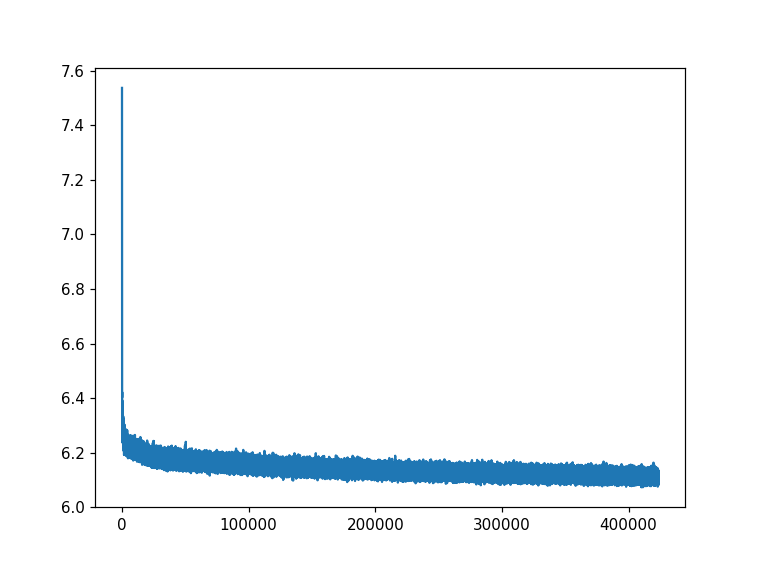

In [84]:
plt.figure()
plt.plot(losses_train)

## Check embeddings

In [85]:
torch.cuda.empty_cache()

In [86]:
features = model(torch.tensor(images_labeled, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_val, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()

In [87]:
_, features_embedded, _, _ = decomposition.torch_pca(features, device=DEVICE, return_cpu=True)

In [89]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, 
                     perplexity=90.0, 
                     early_exaggeration=12.0, 
                     learning_rate=200, 
                     n_iter=1000, 
                     n_iter_without_progress=300, 
                     min_grad_norm=1e-07, 
                     metric='euclidean', 
                     init='pca', 
                     verbose=0, 
                     random_state=None, 
                     method='barnes_hut', 
                     angle=0.5, 
                     n_jobs=-1, 
                     square_distances='legacy'
                    )
features_embedded = tsne.fit_transform(features.cpu())

<IPython.core.display.Javascript object>


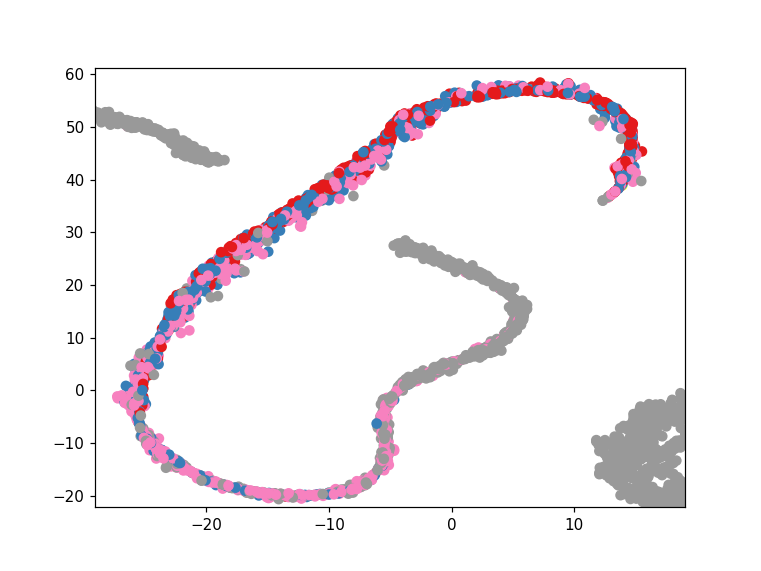

In [90]:
import matplotlib as mpl

mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)
mpl.rcParams['image.cmap'] = 'viridis'


## Check filters

In [91]:
list(model.state_dict().keys())

['cnn_layers.0.weight',
 'cnn_layers.0.bias',
 'cnn_layers.2.weight',
 'cnn_layers.2.bias',
 'cnn_layers.5.weight',
 'cnn_layers.5.bias',
 'cnn_layers.8.weight',
 'cnn_layers.8.bias',
 'linear_layers.0.weight',
 'linear_layers.0.bias',
 'linear_layers.2.weight',
 'linear_layers.2.bias']

<IPython.core.display.Javascript object>


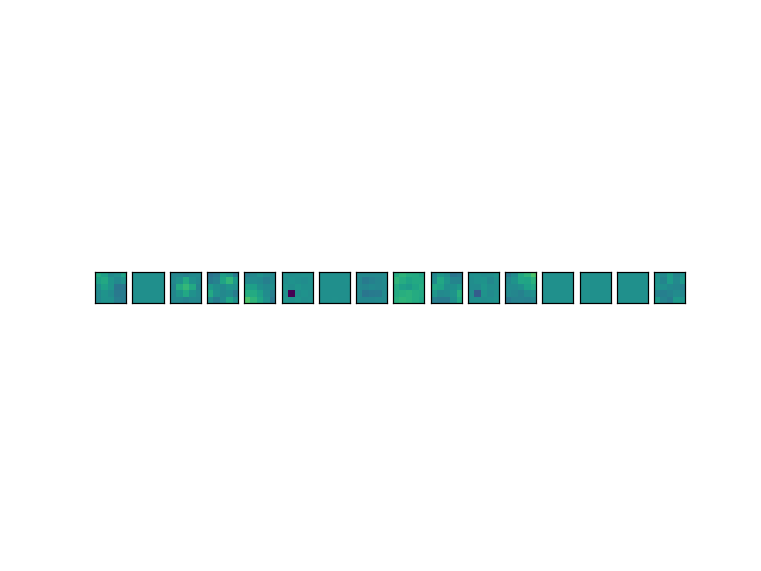

<IPython.core.display.Javascript object>


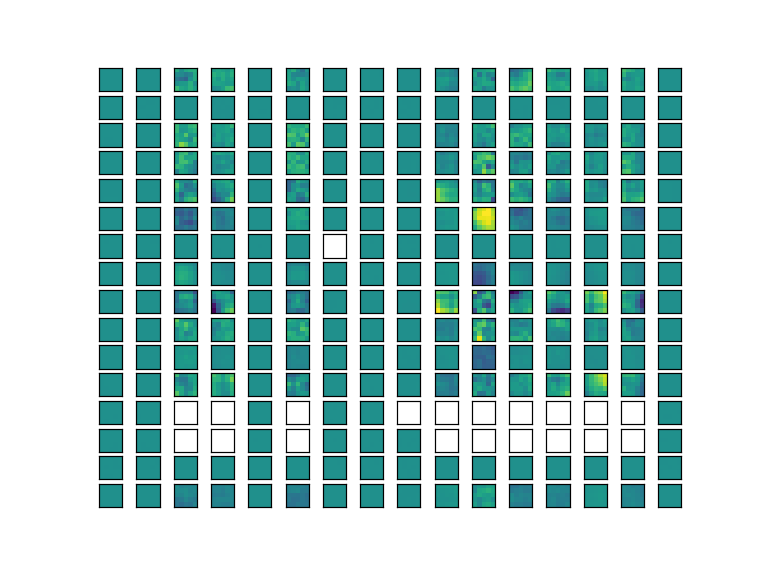

<IPython.core.display.Javascript object>


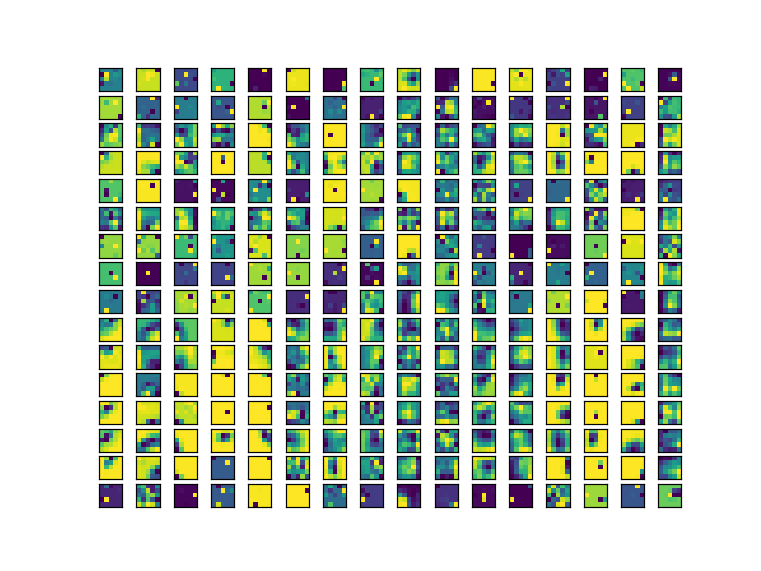

<IPython.core.display.Javascript object>


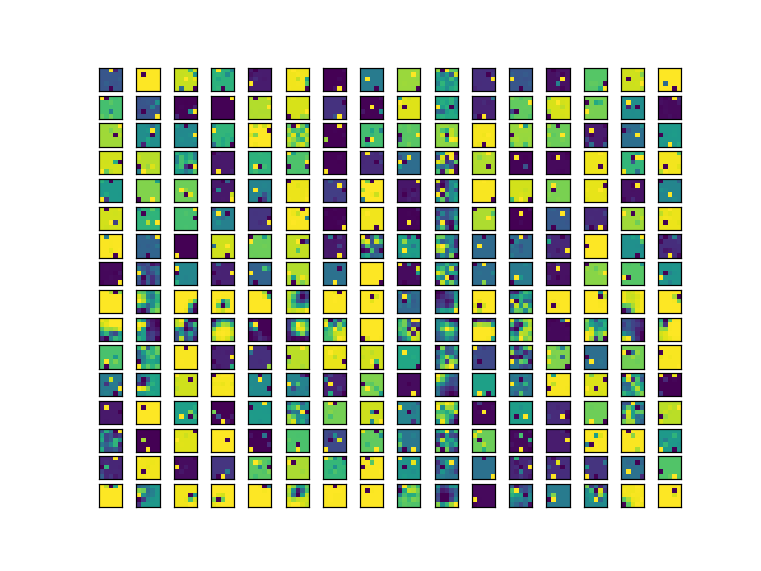

In [92]:
layer_1 = model.state_dict()['cnn_layers.0.weight'].cpu()
layer_2 = model.state_dict()['cnn_layers.2.weight'].cpu()
layer_3 = model.state_dict()['cnn_layers.5.weight'].cpu()
layer_4 = model.state_dict()['cnn_layers.8.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(layer_2.shape[1]):
    for jj in range(layer_2.shape[0]):
        plt.subplot2grid((layer_2.shape[1],layer_2.shape[0]),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [16]:
torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211027_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [15]:
# model = Net()
model.load_state_dict(torch.load('/media/rich/bigSSD/Net_trainedOnAug_20211027_trainingSet_mouse628_20200903and20200815_simCLR.pth'))
# model.eval()
model.train()

LeNet1(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
)